```
❯ ls
dp.ipynb                                noisy_means_experiment_results.csv      noisy_sum_experiment_results.parquet
noisy_counts_experiment_results.csv     noisy_means_experiment_results.parquet  noisy_var_experiment_results.csv
noisy_counts_experiment_results.parquet noisy_sum_experiment_results.csv        noisy_var_experiment_results.parquet
```

In [103]:
# import parquet files as dataframes
import pandas as pd
import pyarrow.parquet as pq
import os
import sys
import numpy as np
from functools import reduce

#eps = [0.177101450509287, 0.2509487223501085, 0.3563228120191924, 0.7304317044395013, 1.6426117097961404, 11.51291546492478, 11.51291546492478, 11.51291546492478, 11.51291546492478]

# read in the parquet files
DATE='2025-02-04'
counts = pq.read_table(f'./dp/{DATE}/dp_basic_count_values.parquet').to_pandas()#.rename(columns={i: eps[i] for i in range(len(eps))})
means = pq.read_table(f'./dp/{DATE}/dp_basic_mean_values.parquet').to_pandas()#.rename(columns={i: eps[i] for i in range(len(eps))})
#sums = pq.read_table(f'./dp/{DATE}/noisy_sum_experiment_results.parquet').to_pandas().T.rename(columns={i: eps[i] for i in range(len(eps))})
#vars = pq.read_table(f'./dp/{DATE}/noisy_var_experiment_results.parquet').to_pandas().T.rename(columns={i: eps[i] for i in range(len(eps))})

mi = counts.columns

In [93]:
counts.shape

(100, 9)

In [95]:
means.shape

(100, 9)

In [97]:
reduce(lambda left, right: pd.merge(left, right, on='mi', how='inner'),[
    counts.melt().astype('float64').rename(columns={'variable': 'mi', 'value': 'count'}),
    means.melt().astype('float64').rename(columns={'variable': 'mi', 'value': 'mean'})
]).shape

(90000, 3)

In [45]:
#counts.columns = counts.columns.astype(float)

In [49]:
counts.columns[0]


'0.00390625'

In [144]:
OUTPUT_COLS = ['count', 'mean']
dfs = [counts, means]#, sums, vars]
out_dfs = []
for query in OUTPUT_COLS:
    df = dfs[OUTPUT_COLS.index(query)]
    results = []
    for mi in df.columns:
        for x in df[mi]:
            results.append([mi, x])
    print(results)
    df = pd.DataFrame(results, columns=['mi', query]).astype('float64')
    out_dfs.append(df)


[['0.00390625', 628.5374551071186], ['0.00390625', 645.8703271203859], ['0.00390625', 653.0862658099282], ['0.00390625', 646.7708999310662], ['0.00390625', 642.8513072385863], ['0.00390625', 640.11388793581], ['0.00390625', 654.7786264233896], ['0.00390625', 665.6387539726146], ['0.00390625', 638.5026369537646], ['0.00390625', 649.5182834200629], ['0.00390625', 635.5544532390409], ['0.00390625', 651.1286498612865], ['0.00390625', 653.7098742522], ['0.00390625', 655.0635747189546], ['0.00390625', 648.2522794771878], ['0.00390625', 646.2917942415905], ['0.00390625', 648.2024652714821], ['0.00390625', 656.4409877676081], ['0.00390625', 635.8815730420855], ['0.00390625', 648.0216288392457], ['0.00390625', 658.2183418229018], ['0.00390625', 649.2481090957377], ['0.00390625', 647.5788279395618], ['0.00390625', 652.9335658010871], ['0.00390625', 649.537842986584], ['0.00390625', 647.7428539826126], ['0.00390625', 634.6175255491526], ['0.00390625', 648.9066755083301], ['0.00390625', 647.041815

In [145]:
df = pd.concat(out_dfs, axis=1)
# deduplicate columns
df = df.loc[:,~df.columns.duplicated()]
df['sum'] = df['count'] * df['mean']
df = df[['mi', 'count', 'sum', 'mean']]
df

,mi,count,sum,mean
0,0.003906,628.537455,2429.761169,3.865738
1,0.003906,645.870327,2043.327919,3.163681
2,0.003906,653.086266,2665.629161,4.081588
3,0.003906,646.770900,2432.331776,3.760732
4,0.003906,642.851307,2246.435064,3.494486
...,...,...,...,...
895,16.000000,648.999477,2374.755286,3.659102
896,16.000000,648.727144,2372.603137,3.657321
897,16.000000,649.384486,2380.617120,3.665959
898,16.000000,649.058371,2373.732448,3.657194


In [146]:
df.to_parquet('./outputs/dp_results.parquet')

In [134]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

true_result = np.array([ 649.        , 2375.        ,    3.65947612])

In [148]:
# compute errors for DP (or import from saved file)
OUTPUT_COLS = ['count', 'sum', 'mean']
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

errors_list = []
for i, row in df.iterrows():
    mi = row['mi']
    r = row[['count', 'sum', 'mean']].to_numpy()
    errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
dp_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,0.003906,20.462545,54.761169,0.206262,3.152934,2.305733,5.636379
1,0.003906,3.129673,331.672081,0.495795,0.482230,13.965140,13.548244
2,0.003906,4.086266,290.629161,0.422112,0.629625,12.237017,11.534767
3,0.003906,2.229100,57.331776,0.101256,0.343467,2.413970,2.766940
4,0.003906,6.148693,128.564936,0.164990,0.947410,5.413260,4.508565
...,...,...,...,...,...,...,...
895,16.000000,0.000523,0.244714,0.000374,0.000081,0.010304,0.010223
896,16.000000,0.272856,2.396863,0.002156,0.042043,0.100921,0.058903
897,16.000000,0.384486,5.617120,0.006483,0.059243,0.236510,0.177163
898,16.000000,0.058371,1.267552,0.002282,0.008994,0.053371,0.062359


In [136]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

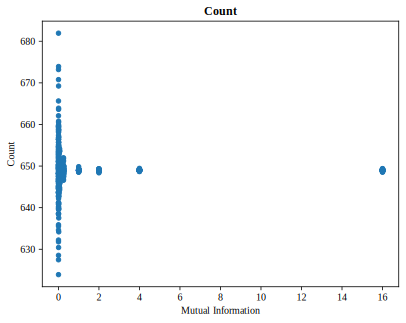

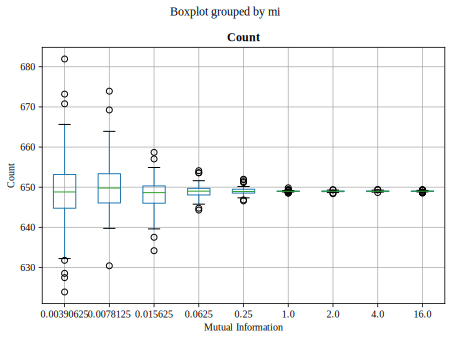

In [147]:
# plot count
fig, ax = plt.subplots()
df.plot.scatter(x='mi', y='count', ax=ax)
ax.set_title('Count')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Count')

# box and whisker plot
fig, ax = plt.subplots()
df.boxplot('count', by='mi', ax=ax)
ax.set_title('Count')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()